# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

--- 

# Importing Libraries and Loading Data

Importing the necessary Python libraries and loads data from JSON files into Pandas DataFrames.

### Libraries Imported
- `pandas` (`pd`): Used for data manipulation and analysis.
- `numpy` (`np`): Provides support for numerical operations.
- `math`: Standard Python library for mathematical functions.
- `json`: Enables working with JSON data.
- `matplotlib.pyplot` (`plt`): Used for data visualization.
- `seaborn` (`sns`): Enhances visualization with statistical plotting.

### Loading Data
The `pd.read_json()` function is used to read JSON files:
- `portfolio_raw`: Contains data from `portfolio.json`, likely representing promotional offers.
- `profile_raw`: Contains data from `profile.json`, likely storing user demographic information.
- `transcript_raw`: Contains data from `transcript.json`, likely recording user interactions or transactions.

Each file is read with `orient='records'` and `lines=True`, ensuring that each JSON object in the file is interpreted as a separate record (suitable for line-delimited JSON files).


In [1]:
import pandas as pd
import numpy as np
# import math
# import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio_raw = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_raw = pd.read_json('data/transcript.json', orient='records', lines=True)


# Data understanding

--- 
Objectives: 

* Examination of each individual table and its corresponding columns.
* Exploratory data analysis (EDA) with some statistics.
---


**portfolio.json:**

 Ten offers type and his atributes.

-> Data is cleaned and ready to be used

In [2]:
portfolio_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [3]:
# showing the entire table
portfolio_raw

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**profile.json**

Customers demographic data.

--> There are 17000 customers in the dataset.

--> There are 2175 (~12,7 %) NoneType values in `gender` and `income`, and the `age` values is 118 for these.

--> ~50 % are 'M' and ~36 % are 'F'. There is ~1.2 %  'O' type gender.

--> The colum `became_member_on` has non-formated date values.*

--> There are no  missing values.

In [4]:
profile_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
profile_raw['gender'].value_counts(dropna=False, normalize=True)

gender
M       0.499059
F       0.360529
None    0.127941
O       0.012471
Name: proportion, dtype: float64

In [6]:
profile_raw['age'].value_counts(dropna=False, normalize=True)

age
118    0.127941
58     0.024000
53     0.021882
51     0.021353
59     0.021118
         ...   
100    0.000706
96     0.000471
98     0.000294
101    0.000294
99     0.000294
Name: proportion, Length: 85, dtype: float64

In [7]:
profile_raw.describe(include='all') 

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,e4052622e5ba45a8b96b59aba68cf068,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


<Axes: xlabel='gender', ylabel='age'>

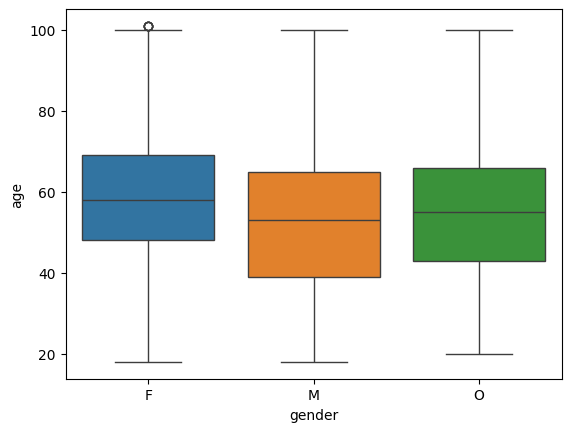

In [8]:
# A boxplot to view the distribution of age per gender
sns.boxplot(data=profile_raw, x="gender", y="age", hue='gender', legend=False)

**transcript.json**

A time line of the events that took place during the simulation event.

--> There is a inconsistent dicttionary keys in the `value` column.

--> The `' '` in the `event` column categorie's names can be normalized to `'_'`.

--> There are no missing values.

In [9]:
transcript_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [10]:
{[*x][0] for x in transcript_raw['value']}

{'amount', 'offer id', 'offer_id'}

In [11]:
transcript_raw['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

# Data Preparation
---
- Objective:

Creation of `Analytical Tables` datasets for analisys, visuals and machine learning applications.

- Strategy:
1. Loading raw data from the original tables.
2. Restructuring it using groupby/unstack and creating fetures.
3. Selecting relevant variables and fetures.

This process ensures that the data tables and **features** is properly formatted, aggregated, and cleaned for further analysis. 

---

#### **Portfolio Dataset**
- Update column `id` to make them more easier to read.

In [12]:
#creating a copy from the original dataframe
portfolio = portfolio_raw.copy() 

# renaming the columns using a dictionary
port_id = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'ofr_A',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'ofr_B',
    '3f207df678b143eea3cee63160fa8bed': 'ofr_C',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'ofr_D',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'ofr_E',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'ofr_F',
    'fafdcd668e3743c1bb461111dcafc2a4': 'ofr_G',
    '5a8bc65990b245e5a138643cd4eb9837': 'ofr_H',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'ofr_I',
    '2906b810c7d4411798c6938adc9daaa5': 'ofr_J'
}

portfolio['ofr_id_short'] = portfolio['id'].map(port_id)

# persist a csv file to the bronze folder
portfolio.to_csv('medalion_data_store/bronze/portfolio.csv', index=False)

portfolio

,reward,channels,difficulty,duration,offer_type,id,ofr_id_short
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ofr_A
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,ofr_B
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,ofr_C
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,ofr_D
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,ofr_E
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,ofr_F
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,ofr_G
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,ofr_H
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,ofr_I
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,ofr_J


#### **Profile Dataset**
- Convert the `became_member_on` column to a standardized **datetime** format for consistency and easier analysis.
-  Create a new column with only the year and month of the date.

In [13]:
# copy the raw data into a new dataframe
profile = profile_raw.copy(deep=True)

# Convert the 'became_member_on' column to a datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Create a new column with only the year and month of the membership
profile['bec_memb_year_month'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.strftime('%Y-%m')

# persist a csv file to the bronze folder

# Create function to categorize age
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif 25 <= age < 40:
        return 'Adult'
    elif 40 <= age < 60:
        return 'Middle'
    else:
        return 'Senior'
    
profile['age_group'] = profile['age'].apply(categorize_age).astype('category')

# Persist a csv file to the bronze folder
profile.to_csv('medalion_data_store/bronze/profile.csv')

profile.head()

,gender,age,id,became_member_on,income,bec_memb_year_month,age_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017-02,Senior
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017-07,Middle
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018-07,Senior
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017-05,Senior
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017-08,Senior


#### **Transcript dataset**
- Clean, normalizing and transforming column values from the transcript orighinal table.
- Creating a new table `transcript_b` using json_normalize() and concat() methods.

**Strategy:**

1. Copy the data.
2. Normalizing the `value` column dictionarie keys `offer id` --> `offer_id`.
3. Creating the `transcript_b` table using `json_normalize` and `concat` functions.
3. Normalizing the `event` column values replacing `' '` --> `'_'`. 
4. Creating `ofr_id_short` column with an id more readeble and droping the `offer_id` column.
5. Fill NaN with apropriate values.
6. Creating a `tag` column to identify the person-event-offer interactions one by one. (as a person can interact with the same offer type more than once)
7. Persist the table in a csv file.

In [14]:
# copy the raw data into a new dataframe
transcript = transcript_raw.copy(deep=True)

# Create a and apply a function to fix the offer_id
def fix_offer_id(value):
    if isinstance(value, dict) and 'offer id' in value:
        value['offer_id'] = value.pop('offer id')
    return value

transcript['value'] = transcript['value'].apply(fix_offer_id)

# Normalize the 'value' column with json_normalize method
value_df = pd.json_normalize(transcript['value']) 
transcript_b = pd.concat([transcript, value_df], axis=1).drop('value', axis=1)

# Normalizing the event column categorie's names
transcript_b['event'] = [x.split(' ')[1] if len(x.split(' ')) > 1 else x for x in transcript_b['event']  ]

# mapping the offer_id to the offer_id_short and Dropping the offer_id column
transcript_b['ofr_id_short'] = transcript_b['offer_id'].map(port_id).fillna('tran')
transcript_b = transcript_b.drop(columns = ['offer_id'])

# fill the missing values in amount and reward with 0
#transcript_b['amount'] = transcript_b['amount'].fillna(0)
#transcript_b['reward'] = transcript_b['reward'].fillna(0)

# creating a tag column to identify the order of the events for each person-offer-event fact
transcript_b['tag'] = (
    transcript_b.groupby(['person', 'ofr_id_short', 'event'], observed=True)
    .cumcount()
)

# persist a csv file to the bronze folder
transcript_b.to_csv('medalion_data_store/bronze/transcript_b.csv')

transcript_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   person        306534 non-null  object 
 1   event         306534 non-null  object 
 2   time          306534 non-null  int64  
 3   amount        138953 non-null  float64
 4   reward        33579 non-null   float64
 5   ofr_id_short  306534 non-null  object 
 6   tag           306534 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 16.4+ MB


### Separating *transactions* events in transcript data from the others

* **Source**: 

    `transcript_b`.

* **Created tables:**

    `events` and `transactions`: separated data from `transcript_b`


- creating `events` and `transactions` dataframes
- Dropping columns that are not needed

In [15]:
# filtering  the data that are different than transaction
events = transcript_b[transcript_b['event'] != 'transaction'].copy()

# drop the 'amount' column as it contais zero for all rows.
events = events.drop(columns=['amount']) 

# filtering  the transaction data 
transactions = transcript_b[transcript_b['event'] == 'transaction'].copy()

# drop the reward (all zeros) and offer_id columns as they are not relevant in this dataset. 
transactions = transactions.drop(columns=['reward',	'ofr_id_short']) 

# persisting the data in the silver layer
events.to_csv('medalion_data_store/bronze/events.csv')
transactions.to_csv('medalion_data_store/bronze/transactions.csv')

In [16]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   person        167581 non-null  object 
 1   event         167581 non-null  object 
 2   time          167581 non-null  int64  
 3   reward        33579 non-null   float64
 4   ofr_id_short  167581 non-null  object 
 5   tag           167581 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 8.9+ MB


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Features Engineering

- Process the datasets to create useful tables and extract fetures from the data.

# User-Item Matrix

Constructing a **User-Item Matrix** from event and transaction data. The matrix is useful for **recommendation systems**.

## Steps

1. **Event Data Processing:**
   - Groups event records by user (`person`), event type, and offer ID (`ofr_id_short`).
   - Counts occurrences of each event per user per offer.
   - Unstacks the grouped data to create a structured table with event types as columns.
   - Fills missing values with zero.

2. **Transaction Data Processing:**
   - Groups transactions by user (`person`) and event type.
   - Counts transactions and sums transaction amounts for each user-event pair.
   - Unstacks the grouped data and fills missing values.

3. **Merging Data:**
   - Merges event and transaction matrices to create a consolidated **user-item interaction dataset**.
   - Merges with user profile data using `id` as the key, forming the final **User-Item Profile**.

## Application

- **Recommendation Systems**: Identifies user engagement with different events and offers.

This structured matrix serves as a foundation for machine learning models, enabling data-driven decision-making.


In [36]:
# user_item_matrix
user_item_cnt_events = transcript_b.groupby(['person', 'event', 'ofr_id_short']).agg( 
    cnt = ('event', 'count'),    
    sum_amt = ('amount', 'count')
    ).unstack(level=[1,2]).reset_index()  #.fillna(0)
user_item_cnt_events.columns = ['_'.join(col).strip('_') for col in user_item_cnt_events.columns.to_flat_index()]

user_item_cnt_events.to_csv('medalion_data_store/gold/user_item_cnt_events.csv', index=False)





# Group event data by person, event, and offer ID, then count occurrences
user_item_events = events.groupby(['person', 'event', 'ofr_id_short']).agg(
    cnt=('event', 'count'),  # Count the occurrences of each event per person per offer
).unstack(level=[1, 2]).reset_index().fillna(0)

# Flatten multi-index column names
user_item_events.columns = ['_'.join(col).strip('_') for col in user_item_events.columns.to_flat_index()]

# Group transaction data by person and event, aggregating count and sum of amounts
user_item_transactions = transactions.groupby(['person', 'event']).agg(
    cnt=('amount', 'count'),  # Count the number of transactions per person per event
    sum=('amount', 'sum')     # Sum of transaction amounts per person per event
).unstack(level=[1]).reset_index().fillna(0)






# Flatten multi-index column names
user_item_transactions.columns = ['_'.join(col).strip('_') for col in user_item_transactions.columns.to_flat_index()]

# Merge event and transaction data on 'person' to form a unified user-item matrix
user_item = user_item_events.merge(user_item_transactions, on='person', how='left')

# Merge with user profile data using 'id' as key and drop redundant 'person' column
user_item_profile = profile.merge(user_item, left_on='id', right_on='person', how='left').drop(columns=['person'])

user_item_profile.to_csv('medalion_data_store/gold/user_item_profile.csv', index=False)

# Output final user-item profile matrix
user_item_profile

,gender,age,id,became_member_on,income,bec_memb_year_month,age_group,cnt_completed_ofr_G,cnt_completed_ofr_I,cnt_completed_ofr_J,...,cnt_viewed_ofr_F,cnt_completed_ofr_B,cnt_received_ofr_A,cnt_received_ofr_B,cnt_viewed_ofr_B,cnt_completed_ofr_A,cnt_viewed_ofr_A,cnt_viewed_ofr_J,cnt_transaction,sum_transaction
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017-02,Senior,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,20.40
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017-07,Middle,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,77.01
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018-07,Senior,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,14.30
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017-05,Senior,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,159.27
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017-08,Senior,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018-06,Middle,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7.0,20.03
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018-07,Senior,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,25.97
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017-01,Middle,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,39.74
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016-03,Senior,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,189.67


# Churn Prediction

Constructing a **Churn Prediction Table** based on transaction data. It captures key features such as **recency, frequency, and value** to determine customer churn.

## Features

1. **Recency:**
   - Measures the time since the last recorded transaction.
   - Computed as `714 - max(transaction time per person)`.
   - A higher value indicates that a user has not interacted recently.

2. **Frequency:**
   - Tracks the number of transactions made by a customer in defined time periods (periods start as full time (714h) and are reduced 20 times by ~36h)
   - Sum of transaction counts across these 20 periods.

3. **Value:**
   - Represents the **average** value of transactions per customer.
   - Useful for understanding the spending behavior of each user.

4. **Churn Definition:**
   - **Primary Churn (`churn`)**: A user is considered churned (`1`) if no transactions occurred in the last three periods.
   - **Alternative Churn (`churn2`)**: A user is marked as churned (`1`) if the recency is greater than 96 hours.

## Application

- **Customer Retention Strategies**: Identifies users at risk of churning, enabling proactive engagement.
- **Marketing Campaigns**: Targets high-value customers with tailored offers.
- **Revenue Optimization**: Helps predict potential loss due to customer inactivity.

This structured dataset can be utilized for machine learning models to forecast churn and enhance business decision-making.


In [ ]:
# Aggregate transaction counts per user over time
transactions_time = (
    transactions.groupby(['person', 'time'])
    .size()
    .unstack(level=1, fill_value=0)
    .reset_index()
)

# Rename columns to indicate transaction counts over time
transactions_time.columns = [
    f"time_tran_{col}" for col in transactions_time.columns.to_flat_index()
]

# Compute transaction frequencies over defined periods (~60 hours per period)
frequences_period = pd.DataFrame({
    f'period_{i//6 + 1}': transactions_time.iloc[:, i+1:].sum(axis=1)
    for i in range(0, 119, 6)
})

# Compute recency: Time elapsed since last transaction (714 - max transaction time per person)
recency = (714 - transactions.groupby('person')['time'].max()).reset_index(drop=True)

# Compute average transaction value per user
value = transactions.groupby('person')['amount'].mean().reset_index(drop=True)

# Define churn as 1 if no transactions occurred in the last three periods
churn = pd.Series((frequences_period.iloc[:, -3:].sum(axis=1) == 0).astype(int), name='churn')

# Alternative churn definition: 1 if recency is greater than 96 hours
churn2 = pd.Series((recency > 96).astype(int), name='churn2')

# Combine all features into a final churn prediction table
churn_table = pd.concat([
    transactions_time, frequences_period, recency, value, churn, churn2
], axis=1)

# Save churn data to a CSV file
churn_table.to_csv('medalion_data_store/gold/churn_table.csv', index=False)

# Output the churn table
churn_table


,time_tran_person,time_tran_0,time_tran_6,time_tran_12,time_tran_18,time_tran_24,time_tran_30,time_tran_36,time_tran_42,time_tran_48,...,period_15,period_16,period_17,period_18,period_19,period_20,time,amount,churn,churn2
0,0009655768c64bdeb2e877511632db8f,0,0,0,0,0,0,0,0,0,...,6,5,4,3,3,2,18,15.950000,0,0
1,00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,240,1.363333,1,1
2,0011e0d4e6b944f998e987f904e8c1e5,0,0,0,0,0,0,0,0,0,...,3,3,3,2,1,0,60,15.892000,0,0
3,0020c2b971eb4e9188eac86d93036a77,0,0,0,0,0,0,0,0,0,...,4,3,2,2,2,2,6,24.607500,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,0,0,0,0,1,0,...,2,2,2,1,1,0,42,12.837500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,0,1,0,0,1,0,0,0,0,...,3,2,0,0,0,0,162,52.816364,1,1
16574,fff7576017104bcc8677a8d63322b5e1,0,0,0,0,0,0,1,0,0,...,3,3,2,1,1,1,18,4.990000,0,0
16575,fff8957ea8b240a6b5e634b6ee8eafcf,0,0,0,1,0,0,0,0,0,...,1,1,1,0,0,0,138,2.430000,1,1
16576,fffad4f4828548d1b5583907f2e9906b,0,0,0,0,0,0,1,0,0,...,4,3,2,1,1,0,36,7.402500,0,0


---
## Event-Person and Offer-Person Summary Features

These features provide insights into (overviwed) *how frequently* and *when* users interact with different events and offers.

* **Source**: 

    `transcript_b` table.

* **Created tables:**
    
    `event_person_summary` and `offer_person_summary` with features

    A intermediate table `transcript_features` is created by merging `event_person_summary` and `offer_person_summary`.

    A final table `transcript_features_profile` is created by merging `transcript_features` with `profile`.

### Feature Engineering strategy:
The code groups data by `person`-`event` columns for *offer-person* summary & `person`-`ofr_id_short` columns for *event-person* summary, then computes the following statistics:

- **Event or Offer type Counts (`cnt`)**: Number of occurrences of each event/offer type per person.
- **Average Time (`avg_time`)**: Mean timestamp of each event/offer type per person.
- **Maximum Time (`max_time`)**: Latest occurrence timestamp of each event/offer type per person.
- **Minimum Time (`min_time`)**: Earliest occurrence timestamp of each event/offer type per person.

### Data Transformation
- The `.unstack()` function pivots the `event` or the `ofr_id_short` column, converting different event/offer types into separated columns and filling it's values as above.

- No further calculations are performed on the data columns, as the summary statistics are computed directly from the groupby/unstack operations.

- The resulting multi-level column names are flattened using list comprehension to create more readable column names.


---

In [ ]:
# operating counts and time-statistics with focus on *events*
event_person_summary = transcript_b.groupby(['person', 'event']).agg( 
    cnt = ('event', 'count'),
    avg_time = ('time', 'mean'),
    max_time = ('time', 'max'),
    min_time = ('time', 'min')
    
    ).unstack(level=1).reset_index()  

# rename multi-level columns    
# fill time missing values with 10000 
# fill counting missing values with 0
event_person_summary.columns = ['_'.join(col).strip('_') for col in event_person_summary.columns.to_flat_index()]
event_person_summary.iloc[:,1:5] = event_person_summary.iloc[:,1:5].fillna(0)
event_person_summary = event_person_summary.fillna(10000)

# operating counts and time-statistics with focus on *offers*
offer_person_summary = transcript_b.groupby(['person', 'ofr_id_short']).agg(
    cnt = ('ofr_id_short', 'count'),
    avg_time = ('time', 'mean'),
    max_time = ('time', 'max'),
    min_time = ('time', 'min')
    
    ).unstack(1).reset_index()  

# rename multi-level columns    
# fill time missing values with 10000 
# fill counting missing values with 0
offer_person_summary.columns = ['_'.join(col).strip('_') for col in offer_person_summary.columns.to_flat_index()]
offer_person_summary.iloc[:,1:12] = offer_person_summary.iloc[:,1:12].fillna(0)
offer_person_summary = offer_person_summary.fillna(10000)

# merging the two dataframes
transcript_features = offer_person_summary.merge(event_person_summary, on='person', how='left').reset_index(drop=True)

# dropping duplicated columns: ['ofr_id_short'] == tran and ['event'] == transaction conteins the same information
#transcript_features = transcript_features.drop(columns=['min_time_tran', 'avg_time_tran', 'max_time_tran']) 

transcript_features_profile = profile.merge(transcript_features, left_on='id', right_on='person', how='left').reset_index(drop=True).drop(columns=['id'])

transcript_features_profile.to_csv('medalion_data_store/silver/transcript_features_profile.csv', index=False)

transcript_features_profile

,gender,age,became_member_on,income,bec_memb_year_month,age_group,person,cnt_ofr_A,cnt_ofr_B,cnt_ofr_C,...,avg_time_transaction,avg_time_viewed,max_time_completed,max_time_received,max_time_transaction,max_time_viewed,min_time_completed,min_time_received,min_time_transaction,min_time_viewed
0,None,118,2017-02-12,NaN,2017-02,Senior,68be06ca386d4c31939f3a4f0e3dd783,0.0,0.0,0.0,...,527.333333,411.6,552.0,576.0,696.0,582.0,552.0,168.0,360.0,216.0
1,F,55,2017-07-15,112000.0,2017-07,Middle,0610b486422d4921ae7d2bf64640c50b,0.0,0.0,1.0,...,230.000000,10000.0,528.0,504.0,528.0,10000.0,528.0,408.0,18.0,10000.0
2,None,118,2018-07-12,NaN,2018-07,Senior,38fe809add3b4fcf9315a9694bb96ff5,0.0,0.0,0.0,...,456.000000,417.0,10000.0,576.0,696.0,666.0,10000.0,168.0,132.0,168.0
3,F,75,2017-05-09,100000.0,2017-05,Senior,78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,0.0,...,308.571429,303.0,510.0,504.0,534.0,582.0,132.0,0.0,132.0,6.0
4,None,118,2017-08-04,NaN,2017-08,Senior,a03223e636434f42ac4c3df47e8bac43,0.0,0.0,2.0,...,370.000000,322.0,10000.0,576.0,612.0,624.0,10000.0,0.0,234.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,2018-06-04,54000.0,2018-06,Middle,6d5f3a774f3d4714ab0c092238f3a1d7,0.0,2.0,0.0,...,319.714286,484.0,10000.0,576.0,690.0,588.0,10000.0,336.0,60.0,402.0
16996,M,61,2018-07-13,72000.0,2018-07,Senior,2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.0,1.0,...,355.714286,42.0,420.0,504.0,654.0,42.0,420.0,0.0,126.0,42.0
16997,M,49,2017-01-26,73000.0,2017-01,Middle,01d26f638c274aa0b965d24cefe3183f,0.0,0.0,1.0,...,435.000000,396.0,10000.0,336.0,672.0,396.0,10000.0,0.0,204.0,396.0
16998,F,83,2016-03-07,50000.0,2016-03,Senior,9dc1421481194dcd9400aec7c9ae6366,3.0,3.0,0.0,...,423.000000,494.0,594.0,576.0,684.0,624.0,360.0,336.0,24.0,342.0


---
## Events Summary Features
Tracking offers interactions in events table. This is a new table that tracks general count-time interactions with an offer.

* **Source table**: 

    `events`: event type and time per person interactions with offers.

* **Created table:**
    
   `offer_event_features`: counting and time-based features for each offer.

### Feature Engineering Strategy:

- Each *offers* is grouped and stacked into `event` columns, counting `event` values accordingly. Time satatistics are computed.
- Count-event and time-event colunm are created.

#### Handling Missing Values
- the time missing values are filled with 10000. 

---

In [21]:
# grouping the facts for counting events  (not using the tag column).
offer_event_features = events.groupby(['ofr_id_short', 'event'], dropna=False).agg(
    cnt=('ofr_id_short', 'count'),
    mean_time = ('time', 'mean'),
    max_time = ('time', 'max'),
    min_time = ('time', 'min')
).unstack(level=1).round(1).reset_index()

offer_event_features.iloc[:,1:4] = offer_event_features.iloc[:,1:4].fillna(0)
offer_event_features = offer_event_features.fillna(10000)

# Flattening the multi-level column names
offer_event_features.columns = ['_'.join(col).strip('_') for col in offer_event_features.columns.to_flat_index()]

offer_event_features.to_csv('medalion_data_store/silver/offer_event_features.csv', index=False)

offer_event_features

,ofr_id_short,cnt_completed,cnt_received,cnt_viewed,mean_time_completed,mean_time_received,mean_time_viewed,max_time_completed,max_time_received,max_time_viewed,min_time_completed,min_time_received,min_time_viewed
0,ofr_A,3688.0,7658.0,6716.0,394.8,329.8,352.6,714.0,576.0,714.0,0.0,0.0,0.0
1,ofr_B,3331.0,7593.0,7298.0,385.7,335.2,353.1,696.0,576.0,714.0,0.0,0.0,0.0
2,ofr_C,0.0,7617.0,4144.0,10000.0,331.9,358.6,10000.0,576.0,714.0,10000.0,0.0,0.0
3,ofr_D,4354.0,7677.0,4171.0,407.1,334.1,362.0,714.0,576.0,714.0,0.0,0.0,0.0
4,ofr_E,3420.0,7668.0,2663.0,431.5,331.3,366.7,714.0,576.0,714.0,0.0,0.0,0.0
5,ofr_F,5156.0,7646.0,7337.0,400.3,336.4,354.7,714.0,576.0,714.0,0.0,0.0,0.0
6,ofr_G,5317.0,7597.0,7327.0,399.1,330.5,348.9,714.0,576.0,714.0,0.0,0.0,0.0
7,ofr_H,0.0,7618.0,6687.0,10000.0,332.5,353.9,10000.0,576.0,714.0,10000.0,0.0,0.0
8,ofr_I,4296.0,7571.0,7264.0,382.9,332.2,349.8,696.0,576.0,714.0,0.0,0.0,0.0
9,ofr_J,4017.0,7632.0,4118.0,410.0,332.0,356.2,714.0,576.0,714.0,0.0,0.0,0.0


## Transactions Summary Features

This section of the code aggregates transaction data at the `person` level, creating summary statistics that describe each individual's spending behavior. The goal is to generate features that help analyze transaction patterns.

* **Source table**: 

    `transaction`: event type and time per person interactions with offers.

* **Created table:**
    
    `transac_amount_sumary`: intermediate table with summary statistics for each person.
    
    `transac_amount_sumary_profile`: final table merged with `profile` table.

**Strategy:**

The code groups transactions by `person` and computes various summary statistics on the `amount` spent:

- **Total Transaction Amount (`tran_amoun_tot`)**: Sum of all transaction amounts for each person.
- **Average Transaction Amount (`tran_amoun_mean`)**: Mean transaction amount per person, indicating typical spending behavior.
- **Maximum Transaction Amount (`tran_amoun_max`)**: Highest transaction amount recorded for each person.
- **Minimum Transaction Amount (`tran_amoun_min`)**: Lowest transaction amount recorded for each person.

### Additional Considerations
- `tran_amount_std` (standard deviation of transaction amounts), are commented out. 
- The `.round(1)` function rounds all numerical values to one decimal place for cleaner representation.

In [22]:
# grouping  by person
transac_amount_sumary = transactions.groupby(['person'], dropna=False).agg(
    tran_count=('amount', 'count'),
    tran_amoun_tot =('amount', 'sum'),
    tran_amoun_mean=('amount', 'mean'),
    tran_amoun_max=('amount', 'max'),
    tran_amoun_min=('amount', 'min'),
    # tran_amount_std = ('amount', 'std')
).round(1)

# merge with profile
transac_amount_features = profile.merge(transac_amount_sumary, left_on='id', right_on='person', how='left').reset_index(drop=True)

transac_amount_features.to_csv('medalion_data_store/silver/transac_amount_features.csv', index=False)

## Creating `unique_event_features` Table by person:

A more datailed table tracking unique person-offer-event time-based interactions to create features to analyze user engagement and responsiveness for each unique interaction person by person.

* **Source table**: 

    `events`: event type and time per person interactions with offers.

* **Created table:**
    
   `unique_event_features`: table of *facts* of unique person-offer-event interactions.

### Fact Definition:

-  A **Fact** represents a unique ocurrence sequence when a person engages with an single offer, and is tracked from the moment the offer is received, viewed, and completed.
- The **'tag'** column created ensures the uniqueness of the fact and *prevents aggregation when a person interacts with the same offer type more than once*. As the aggregation using the tag column return a single value, using agg with 'max', 'min' or 'mean' will return the same value for a fact.

### Feature Engineering Strategy:

- Each *person-event-offer-tag* fact is grouped and stacked into `event` columns, placing `time` and `reward` values accordingly.
- Time-event colunm are created and missing values computed as `NaN` value.

#### Handling Missing Values
- `time_offer_completed`, `time_offer_received`, and `time_offer_viewed` stacked columns have missing values filled with `np.inf` (never ended event), avoiding *artificial* values imputies.

#### Engagement Metrics
Key features to quantify user responsiveness:

- **Time-Differences-help-features** - not included in the final dataset as it contains np.inf values
  - `to_vr`: Time from receiving to viewing - delays in viewing - {0 to inf}
  - `to_cv`: Time from viewing to completion - delays in completions after viewing - {-inf to inf}
  - `to_cr`: Time from receiving to completion - delays in completion, even if viewed or not - {0 to inf}

- **Inverse Time-Based Scores (`1/(x+1) * 100`):** calculated using the previous time differences where x is the time difference.
  - `curiosity_vr`: `{0 to 100}` Measures _speed_ of viewing after receiving.
  - `eagerness_cv`: `{0 to 100} or -1` Measures _speed_ of completion after viewing (`-1` indicates completion before viewing).
  - `overall_cr`: `{0 to 100}` Overall responsiveness from receiving to completion.

- **Counts:** (by fact using tag column to avoid aggregation on the same offer type per person interactions).
  - `count_offer_completed`: Count of completed offers.
  - `count_offer_received`: Count of received offers. 
  - `count_offer_viewed`: Count of viewed offers.

#### Influence Metrics
- **`influence`**: Binary flag (1/0) indicating if an offer was completed after viewing (responsiveness).
- **`ext_influence`**: Binary flag capturing simultaneous viewing and completion (extreme responsiveness).

In [23]:
# Grouping events by 'person', 'ofr_id_short', 'event', and 'tag', then aggregating the maximum 'time' and 'reward' per group and restructuring the DataFrame.
unique_event_features = (
    events.groupby(['person', 'event', 'ofr_id_short', 'tag'], dropna=False)
    .agg(
        time=('time', 'max'),
        reward=('reward', 'max'),
        cnt = ('ofr_id_short', 'count')
    )
    .unstack(level=1)  # Unstacking by 'event' to widen the DataFrame
    .reset_index()
)

# Flattening the multi-level column names
unique_event_features.columns = ['_'.join(col).strip('_') for col in unique_event_features.columns.to_flat_index()]

# Dropping unnecessary reward columns (containing zero for all values)
unique_event_features = unique_event_features.drop(columns=['reward_received', 'reward_viewed'])

# Replacing NaN values with infinity to facilitate time calculations
unique_event_features['time_completed'] = unique_event_features['time_completed'].fillna(np.inf)
unique_event_features['time_received'] = unique_event_features['time_received'].fillna(np.inf)
unique_event_features['time_viewed'] = unique_event_features['time_viewed'].fillna(np.inf)

# Computing time differences for various stages of the offer lifecycle
unique_event_features['to_vr'] = unique_event_features['time_viewed'] - unique_event_features['time_received']
unique_event_features['to_cv'] = unique_event_features['time_completed'] - unique_event_features['time_viewed']
unique_event_features['to_cr'] = unique_event_features['time_completed'] - unique_event_features['time_received']

# Calculating curiosity, eagerness, and overall responsiveness scores
unique_event_features['curiosity_vr'] = (1 / (unique_event_features['to_vr'] + 1)) * 100
unique_event_features['eagerness_cv'] = [(1 / (x + 1))*100 if ((not np.isnan(x)) & (x >=0)) else -1 for x in unique_event_features['to_cv']]
unique_event_features['overall_cr'] = (1 / (unique_event_features['to_cr'] + 1)) * 100

# Defining influence metrics based on time conditions
unique_event_features['influence'] = (
    (~pd.isna(unique_event_features['time_completed'])) & 
    (unique_event_features['time_completed'] != np.inf) &
    (unique_event_features['time_completed'] >= unique_event_features['time_viewed'])
).astype(int)

# Extreme influence is when the offer is viewed and completed at the same time.
unique_event_features['ext_influence'] = (
    (~pd.isna(unique_event_features['time_viewed'])) & 
    (unique_event_features['time_viewed'] != np.inf) & 
    (unique_event_features['time_completed'] == unique_event_features['time_viewed'])
).astype(int)

# Dropping intermediate time calculation columns and others, rounding final values.
unique_event_features = unique_event_features.drop(
    columns=['time_completed', 'time_received', 'time_viewed', 'to_vr', 'to_cv', 'to_cr', 'cnt_received']
).round(1)

# Filling NaN values in columns with 0
unique_event_features = unique_event_features.fillna(0)

# Persisting the data in the gold layer
unique_event_features.to_csv('medalion_data_store/silver/unique_event_features.csv')

# Displaying the final DataFrame
unique_event_features

,person,ofr_id_short,tag,reward_completed,cnt_completed,cnt_viewed,curiosity_vr,eagerness_cv,overall_cr,influence,ext_influence
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,0.0,0.0,1.0,2.7,0.0,0.0,0,0
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,2.0,1.0,1.0,2.7,-1.0,4.0,0,0
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,0.0,0.0,1.0,4.0,0.0,0.0,0,0
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,5.0,1.0,1.0,2.0,-1.0,14.3,0,0
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,2.0,1.0,0.0,0.0,-1.0,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,5.0,1.0,1.0,14.3,4.0,3.2,1,0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,2.0,1.0,1.0,14.3,1.8,1.6,1,0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,2.0,1.0,1.0,5.3,3.2,2.0,1,0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,2.0,1.0,1.0,14.3,100.0,14.3,1,1


In [24]:
unique_event_features.groupby('ofr_id_short')['cnt_completed'].sum().reset_index()

,ofr_id_short,cnt_completed
0,ofr_A,3688.0
1,ofr_B,3331.0
2,ofr_C,0.0
3,ofr_D,4354.0
4,ofr_E,3420.0
5,ofr_F,5156.0
6,ofr_G,5317.0
7,ofr_H,0.0
8,ofr_I,4296.0
9,ofr_J,4017.0


In [25]:
unique_event_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            76277 non-null  object 
 1   ofr_id_short      76277 non-null  object 
 2   tag               76277 non-null  int64  
 3   reward_completed  76277 non-null  float64
 4   cnt_completed     76277 non-null  float64
 5   cnt_viewed        76277 non-null  float64
 6   curiosity_vr      76277 non-null  float64
 7   eagerness_cv      76277 non-null  float64
 8   overall_cr        76277 non-null  float64
 9   influence         76277 non-null  int64  
 10  ext_influence     76277 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 6.4+ MB


In [26]:
unique_event_features.duplicated().sum()

np.int64(0)

In [27]:
unique_event_features['cnt_completed'].value_counts()

cnt_completed
0.0    42698
1.0    33579
Name: count, dtype: int64

In [28]:
unique_event_features['cnt_viewed'].value_counts()


cnt_viewed
1.0    57725
0.0    18552
Name: count, dtype: int64

In [29]:
offer_person_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   person          17000 non-null  object 
 1   cnt_ofr_A       17000 non-null  float64
 2   cnt_ofr_B       17000 non-null  float64
 3   cnt_ofr_C       17000 non-null  float64
 4   cnt_ofr_D       17000 non-null  float64
 5   cnt_ofr_E       17000 non-null  float64
 6   cnt_ofr_F       17000 non-null  float64
 7   cnt_ofr_G       17000 non-null  float64
 8   cnt_ofr_H       17000 non-null  float64
 9   cnt_ofr_I       17000 non-null  float64
 10  cnt_ofr_J       17000 non-null  float64
 11  cnt_tran        17000 non-null  float64
 12  avg_time_ofr_A  17000 non-null  float64
 13  avg_time_ofr_B  17000 non-null  float64
 14  avg_time_ofr_C  17000 non-null  float64
 15  avg_time_ofr_D  17000 non-null  float64
 16  avg_time_ofr_E  17000 non-null  float64
 17  avg_time_ofr_F  17000 non-null 

In [30]:
event_person_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person                17000 non-null  object 
 1   cnt_completed         17000 non-null  float64
 2   cnt_received          17000 non-null  float64
 3   cnt_transaction       17000 non-null  float64
 4   cnt_viewed            17000 non-null  float64
 5   avg_time_completed    17000 non-null  float64
 6   avg_time_received     17000 non-null  float64
 7   avg_time_transaction  17000 non-null  float64
 8   avg_time_viewed       17000 non-null  float64
 9   max_time_completed    17000 non-null  float64
 10  max_time_received     17000 non-null  float64
 11  max_time_transaction  17000 non-null  float64
 12  max_time_viewed       17000 non-null  float64
 13  min_time_completed    17000 non-null  float64
 14  min_time_received     17000 non-null  float64
 15  min_time_transactio

In [31]:
transcript_features_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   person                17000 non-null  object        
 1   cnt_ofr_A             17000 non-null  float64       
 2   cnt_ofr_B             17000 non-null  float64       
 3   cnt_ofr_C             17000 non-null  float64       
 4   cnt_ofr_D             17000 non-null  float64       
 5   cnt_ofr_E             17000 non-null  float64       
 6   cnt_ofr_F             17000 non-null  float64       
 7   cnt_ofr_G             17000 non-null  float64       
 8   cnt_ofr_H             17000 non-null  float64       
 9   cnt_ofr_I             17000 non-null  float64       
 10  cnt_ofr_J             17000 non-null  float64       
 11  cnt_tran              17000 non-null  float64       
 12  avg_time_ofr_A        17000 non-null  float64       
 13  avg_time_ofr_B  

# Analytical table 

A final table mergin selected tables created in the previous steps.

The goals is get different types of dataset to be used in the analysis, modeling and recommendations.

In [32]:
# Merge unique event features with transcript features based on 'person' column
# Use a left join to keep all records from unique_event_features
person_activity = unique_event_features.merge(transcript_features, on='person', how='left')

# Merge transaction amount summary with the existing dataset based on 'person'
# Fill missing values with 0 after the merge
person_activity = person_activity.merge(transac_amount_sumary, on='person', how='left').fillna(0)

# Merge person activity data with profile data based on 'person' and 'id'
# Drop the redundant 'id' column after the merge
person_activity_profile = person_activity.merge(profile, left_on='person', right_on='id', how='left').drop(columns=['id'])

# Merge with portfolio data using 'ofr_id_short' as the key
# Drop the redundant 'id' column after the merge
person_activity_profile = person_activity_profile.merge(portfolio, on='ofr_id_short', how='left').drop(columns=['id'])

# Save the final dataset to a CSV file
person_activity_profile.to_csv('medalion_data_store/gold/person_activity_profile.csv')

# Display the final DataFrame
person_activity_profile


,person,ofr_id_short,tag,reward_completed,cnt_completed_x,cnt_viewed_x,curiosity_vr,eagerness_cv,overall_cr,influence,...,age,became_member_on,income,bec_memb_year_month,age_group,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,0.0,0.0,1.0,2.7,0.0,0.0,0,...,33,2017-04-21,72000.0,2017-04,Adult,0,"[web, email, mobile]",0,4,informational
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,2.0,1.0,1.0,2.7,-1.0,4.0,0,...,33,2017-04-21,72000.0,2017-04,Adult,2,"[web, email, mobile, social]",10,10,discount
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,0.0,0.0,1.0,4.0,0.0,0.0,0,...,33,2017-04-21,72000.0,2017-04,Adult,0,"[email, mobile, social]",0,3,informational
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,5.0,1.0,1.0,2.0,-1.0,14.3,0,...,33,2017-04-21,72000.0,2017-04,Adult,5,"[web, email, mobile, social]",5,5,bogo
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,2.0,1.0,0.0,0.0,-1.0,100.0,0,...,33,2017-04-21,72000.0,2017-04,Adult,2,"[web, email, mobile]",10,7,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,5.0,1.0,1.0,14.3,4.0,3.2,1,...,45,2016-11-25,62000.0,2016-11,Middle,5,"[web, email]",20,10,discount
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,2.0,1.0,1.0,14.3,1.8,1.6,1,...,45,2016-11-25,62000.0,2016-11,Middle,2,"[web, email, mobile, social]",10,10,discount
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,2.0,1.0,1.0,5.3,3.2,2.0,1,...,45,2016-11-25,62000.0,2016-11,Middle,2,"[web, email, mobile]",10,7,discount
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,2.0,1.0,1.0,14.3,100.0,14.3,1,...,45,2016-11-25,62000.0,2016-11,Middle,2,"[web, email, mobile]",10,7,discount


In [33]:
person_activity_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   person                76277 non-null  object        
 1   ofr_id_short          76277 non-null  object        
 2   tag                   76277 non-null  int64         
 3   reward_completed      76277 non-null  float64       
 4   cnt_completed_x       76277 non-null  float64       
 5   cnt_viewed_x          76277 non-null  float64       
 6   curiosity_vr          76277 non-null  float64       
 7   eagerness_cv          76277 non-null  float64       
 8   overall_cr            76277 non-null  float64       
 9   influence             76277 non-null  int64         
 10  ext_influence         76277 non-null  int64         
 11  cnt_ofr_A             76277 non-null  float64       
 12  cnt_ofr_B             76277 non-null  float64       
 13  cnt_ofr_C       